In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [6]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

#X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
#Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))

X_motion_CoM = X_motion_CoM_acceleration
Y_motion_CoM = Y_motion_CoM_acceleration

print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(1927, 20)
(1927, 3)


# Multivariate Linear Regression (CoM Prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
X_motion_CoM.shape

(1927, 20)

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM[:, -1] == 1)[0]
X_motion_CoM_FR_RL = X_motion_CoM[idx_fr_rl_swinging]
Y_motion_CoM_FR_RL = Y_motion_CoM[idx_fr_rl_swinging]
print(X_motion_CoM_FR_RL.shape)
print(Y_motion_CoM_FR_RL.shape)

(969, 20)
(969, 3)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_FR_RL[0, :3]

array([0.10000000149011612, 0.0, 0.0], dtype=object)

In [11]:
Y_motion_CoM_FR_RL[0, :]

array([0.014050214716398557, 2.7661324658367903e-05,
       -0.005854057182301479], dtype=object)

### Linear Regression

In [12]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, -5:-2], # Current motion command
               X_motion_CoM_FR_RL[:, 3:5], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 6:8], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14])) # RR (x, y) position
               
# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9778569161283281
RMSE:  0.009011217260466676
The lowest error is:  2.1749313290103656e-05
The highest error is:  0.028968367124235145
The avg. error is:  0.00677422911411756


In [13]:
model_fr_com_x.coef_

array([[ 1.01320462e-01, -5.55111512e-17,  0.00000000e+00,
         7.43222931e-02, -1.11022302e-16, -8.32667268e-17,
         3.97155487e-01, -3.72202880e-01,  2.32936105e-01,
         2.62902628e-01, -2.28457695e-01,  1.98860449e-01,
         2.83006097e-01,  2.34632940e-02]])

In [14]:
model_fr_com_x.intercept_

array([-0.07492087])

In [15]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0, 0.237936324231, 0.188065700274, 0.234281409653, -0.171743092874, -0.249921495098, 0.161507381121, -0.259071586366, -0.138188475913]])
output = input_ @ model_fr_com_x.coef_.T + model_fr_com_x.intercept_
print(output)

[[-0.02091591]]


Text(0, 0.5, 'Predictions')

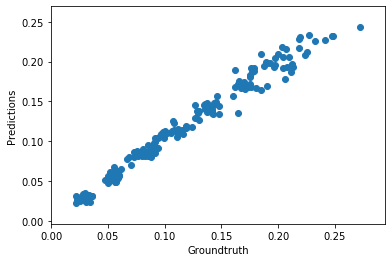

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [17]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> y

### Linear Regression

In [18]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, -5:-2], # Current motion command
               X_motion_CoM_FR_RL[:, 3:5], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 6:8], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -0.3850874379289715
RMSE:  0.002983384457381849
The lowest error is:  5.6646367400825515e-05
The highest error is:  0.011828945429843751
The avg. error is:  0.002291912435472248


In [19]:
model_fr_com_y.coef_

array([[-4.67354517e-03, -6.63531730e-17,  1.38777878e-17,
        -5.44197758e-03,  0.00000000e+00,  0.00000000e+00,
        -8.17415655e-02,  1.30031316e-01, -1.43943314e-01,
        -3.87208199e-01,  1.52531755e-01, -1.51384581e-01,
         8.57435717e-02,  2.08865560e-01]])

In [20]:
model_fr_com_y.intercept_

array([0.09721618])

Text(0, 0.5, 'Predictions')

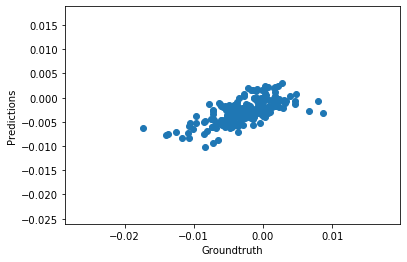

In [21]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [22]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> Yaw

In [23]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, -5:-2], # Current motion command
               X_motion_CoM_FR_RL[:, 3:5], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 6:8], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -7.478694892943004
RMSE:  0.00502372936063886
The lowest error is:  6.46420942825715e-07
The highest error is:  0.035904520928490995
The avg. error is:  0.0029808142102587605


In [24]:
model_fl_com_theta.coef_

array([[ 2.14266772e-02, -1.38777878e-17, -1.38777878e-17,
        -1.24650599e-02,  3.12250226e-17,  4.16333634e-17,
        -6.40214008e-02,  1.79224563e-02, -1.16235715e-01,
        -2.67890125e-01,  1.20880304e-01,  1.84015317e-01,
        -4.19143537e-03, -1.01382016e-01]])

In [25]:
model_fl_com_theta.intercept_

array([0.00209039])

Text(0, 0.5, 'Predictions')

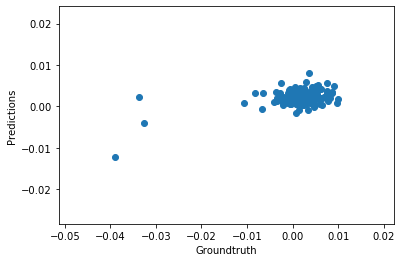

In [26]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")